# Homework 3

Expand upon our understanding of image registration by following the photomosaicking work in the Pizarro2003joe paper

## Part 2
Go around the entire loop of 6 images and set up the problem by outputting vertices and edges in terms of a factor graph. Images that you manage to register in part (b) above can be thought of as loop closure events. <br>
Justify your choice of the covariance (and thus information) matrix that you use for each edge. Once you have completed the loop run a GTSAM script on the output vertices and edges and see how that <br>
(a) Affects the location of individual image centers - your "odometry" (make a plot before and after optimization)<br>
(b) Plot the covariances for each measurement before and after optimization

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os

In [6]:
# Part 1 Functions
def normalize_images(imgs):
    imgs_norm = []
    for img in imgs:
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        imgs_norm.append(img_norm)
    return imgs_norm

def grayscale_images(imgs):
    imgs_gray = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply CLAHE to grayscale images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        imgs_gray.append(clahe.apply(gr))
    return imgs_gray

def find_features(sift_object, imgs_gray):
    kp = []
    des = []
    imgs_sift = []
    for img in imgs_gray:
        k, d = sift_object.detectAndCompute(img,None)
        img_sift = cv2.drawKeypoints(img, k, img, color=[255,255,0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imgs_sift.append(img_sift)
        kp.append(np.array(k))
        des.append(np.array(d))
    return kp, des, imgs_sift

def get_matches(kp1, des1, kp2, des2):
    # FLANN parameters https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann_match = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    good = []

    # ratio test as per Lowe's paper
    for m,n in flann_match:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.array([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.array([kp2[m.trainIdx].pt for m in good])

    return (src_pts, dst_pts)

def get_all_matches(kp, des):
    matches = []
    if len(kp) == 6:
        last_img_match = 0
    elif len(kp) == 28:
        last_img_match = 13
    else:
        print("Length of keypoints not expected")
        
    for i in range(len(kp)):
        ii = i+1 if i < len(kp)-1 else last_img_match
        matches.append(get_matches(kp[i], des[i], kp[ii], des[ii]))
        print("Image: ", i, ", ", ii, " Matches: ", len(matches[i][0]))

    return matches


def get_homography(kp_match_inliers):
    h = []
    pts_left_src = []
    pts_right_dst = []
    mask = []

    # if inliers were not already given to the homography function, get points and do RANSAC
    for kp_match in kp_match_inliers:
        pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
        pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))

    # this is only for the last run
    for i in range(len(pts_left_src)):
        h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,3.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask, (pts_left_src, pts_right_dst)

def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = cv2.getPerspectiveTransform(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape[:2], img_dst.shape[:2])

    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    # Blend images together
    black = np.zeros((stitched_dims[0], stitched_dims[1], 3), dtype=np.uint8)
    mask_dst = cv2.inRange(dst_transformed, np.array([0,0,0]), np.array([0,0,0]))
    mask_src = cv2.inRange(src_warped, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_dst)
    src_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(src_warped, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(dst_transformed, black, mask=overlap_region), 0.5, 0.0)

    # Combine all components of the image together
    img_stitched = dst_fringe + src_fringe + img_overlap_blend

    return img_stitched, offset

In [7]:
# Save images in a list
imgs = []
dir_name = 'Part1_6Images/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )

for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))

imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)
img_h, img_w = imgs_gray[0].shape

# Create SIFT Object and save keypoints, descriptors, and sift-labeled images
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)
kp, des, imgs_sift = find_features(sift, imgs_gray)

matches = get_all_matches(kp, des)

Image:  0 ,  1  Matches:  548
Image:  1 ,  2  Matches:  482
Image:  2 ,  3  Matches:  53
Image:  3 ,  4  Matches:  575
Image:  4 ,  5  Matches:  398
Image:  5 ,  0  Matches:  47


(-0.5, 834.5, 654.5, -0.5)

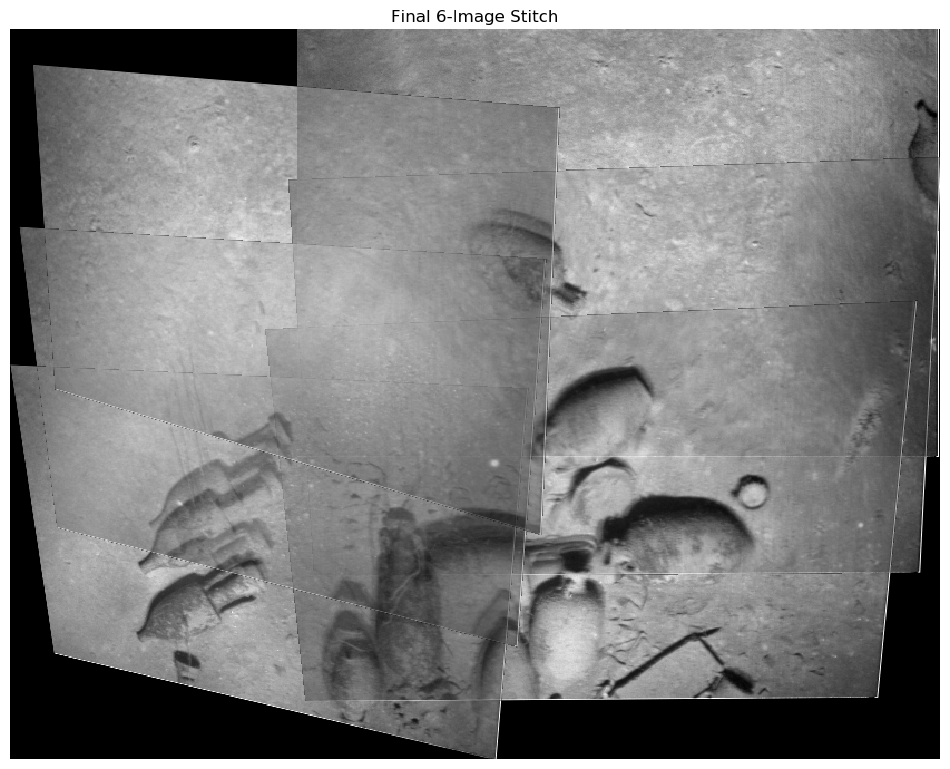

In [8]:
h, mask, pts_corr = get_homography(matches)

t = [0,0]
#mosaicImgs = []
for i in range(len(h)-1):
    #print(h[i])
    h[i][0][2] += t[0]
    h[i][1][2] += t[1]
    if i != 0:
        h[i] = np.dot(h[i],h[i-1])
    if i == 0:
        mosaicImg, t = stitch_images(imgs_norm[i],imgs_norm[i+1],h[i])
        

    elif i > 0 and i < len(h):
        mosaicImg, t = stitch_images(mosaicImg,imgs_norm[i+1],h[i])
        
    else:
        mosaicImg, t = stitch_images(mosaicImg,imgs_norm[0],h[i])
    
    #mosaicImgPrev = mosaicImg
    #t = tNew
plt.figure(figsize = (12,12))
plt.imshow(mosaicImg)
plt.title("Final 6-Image Stitch")
plt.axis('off')

https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

Get Matches. If I run this multiple times, I get different matches and results that drastically degrade the final stitch

With matches for each image pair, perform RANSAC on the match points to get the inliers.

### Compute Homography using Levenberg Marquadt

Code from previous homework to stitch two images

SIFT Hyperparameter Tuning: https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html

Start Part 2

In [9]:
#import g2o
import gtsam
import gtsam.utils.plot

In [10]:
def getOdometryNoise(mask):
    numMatches = np.count_nonzero(mask)
    # define error lists in the form of [xerr,yerr,theta_err]
    minError = [0.2, 0.2, 0.1]
    smallError = [0.5, 0.5, 0.25]
    largeError = [0.8, 0.8, 0.4]
    maxError = [1.0, 1.0, 0.5]
    
    if numMatches > 100:
        err = minError
    elif numMatches > 50 and numMatches <= 100:
        err = smallError
    elif numMatches > 20 and numMatches <= 50:
        err = largeError
    else:
        # less than 20 inlier matches
        err = maxError
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

In [12]:


PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()

# add a prior on the first pose at origin (image 0 center)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(img_w/2, img_h/2, 0), PRIOR_NOISE))

In [14]:
ransac_mask = []
def getFactorPose(index, pts_src = pts_corr[0], pts_dst = pts_corr[1]):
    global ransac_mask
    #if len(pts_src) > 4:
        # pts_src and pts_dst do not need to be iterated through
        # keep src/dst order consistent
    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])
    scale = np.sqrt(similarity_mat[0, 0]**2+similarity_mat[1, 0]**2)
    similarity_mat[:2, :2] /= scale
    affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))
    # NOTE: INVERTED ON 01MAR
    #affine_matrix = np.linalg.inv(affine_matrix)
    #print(affine_matrix)
    return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))
    #else:
        # return gtsam version of None
        #return None # TODO: Check this
        
getFactorPose(0)

(-6.94842, 127.758, -0.011561)

In [15]:
def extractHomographyPose(h):
   affineEst = h
   affineEst[2][0] = 0
   affineEst[2][1] = 0
   #print(affineEst)
   scale = np.sqrt(affineEst[0,0]**2+affineEst[1,0]**2) # adapted from ZZ
   affineEst[:2, :2] /= scale
   rot = affineEst[:2, :2]
   total_affine_matrix = np.eye(3)

   affineEst_inv = np.linalg.inv(affineEst)
   affineEst = affineEst_inv.dot(total_affine_matrix)
   return gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                  np.arctan2(affineEst[1, 0], affineEst[0, 0]))

In [16]:
def initialEstimates(h):
    initial_estimate = gtsam.Values()
    initial_estimate.insert(0, gtsam.Pose2())
    
    for i in range(len(h)-1):
        initial_estimate.insert(i+1, extractHomographyPose(h[i]))
        
    return initial_estimate

initial = initialEstimates(h)

In [17]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

In [18]:
import itertools

# nonlinear graph initialization done earlier
for src_index, dst_index in itertools.combinations(range(len(imgs_norm)), 2):
    
    if src_index + 1 == dst_index:
        graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                               getFactorPose(src_index), getOdometryNoise(mask[src_index])))
            
  

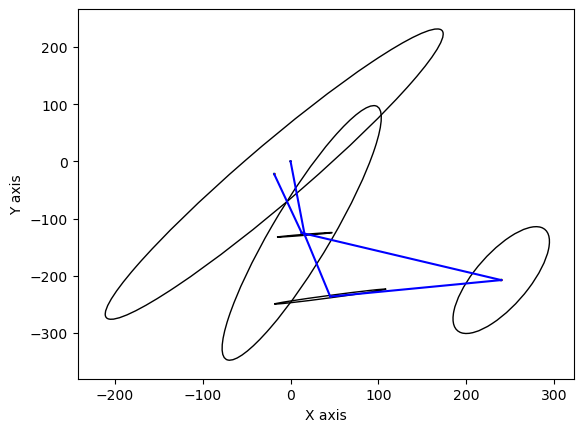

In [19]:
 #graph = build_graph(initial)
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [20]:
# nonlinear graph initialization done earlier
for src_index, dst_index in itertools.combinations(range(len(imgs_norm)), 2):
    #print(dst_index)
    #print(check_overlap(initial.atPose2(src_index), initial.atPose2(dst_index)))

    if src_index + 1 == dst_index:
        graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                               getFactorPose(src_index), getOdometryNoise(mask[src_index])))
            
    else: 
    # 
    #elif src_index + 2 == dst_index or src_index - 2 == dst_index or src_index - 1 == dst_index:
    #elif src_index + 2 == dst_index or src_index - 2 == dst_index or src_index - 1 == dst_index or dst_index % 7 < 3:
    #elif check_overlap(initial.atPose2(src_index), initial.atPose2(dst_index)):
        # NOTE: Need to change this to check only images immediately next to it
        #homog, maskIm = registerTwoImages(normImgs,src_index,dst_index,kp,des)


        kp_match_overlap = [get_matches(kp[src_index], des[src_index], kp[dst_index], des[dst_index])]
        
        print(len(kp_match_overlap[0][0]))
        if len(kp_match_overlap[0][0]) < 20: continue
        homog, maskIm, _ = get_homography(kp_match_overlap)

        pts_left_overlap = []
        pts_right_overlap = []
        for kp_matches in kp_match_overlap:
            pts_left_overlap.append(np.float32([kp_matches[0][i] for i in range(len(kp_matches[0]))]))
            #print(pts_left_src)
            pts_right_overlap.append(np.float32([kp_matches[1][i] for i in range(len(kp_matches[1]))]))

        #print(len(pts_left_overlap[0]))
        factor_pose = getFactorPose(0, pts_left_overlap, pts_right_overlap)
        #print(factor_pose)
        if factor_pose is not None:
            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                factor_pose, getOdometryNoise(ransac_mask)))

93
2
13
49
15
32
69
27
13
102


In [473]:
for src_index, dst_index in itertools.combinations(range(len(imgs_norm)), 2):
    if src_index + 1 != dst_index:
        print(currSomething)
        if currSomething < 20: continue
            
        kpList = [kp[src_index],kp[dst_index]]
        desList = [des[src_index],des[dst_index]]
        
        match_overlap = [getFLANNMatches(kpList[0],desList[0], kpList[1],desList[1])]
        print(currSomething)

        pts_left_overlap = []
        pts_right_overlap = []            
        
        for matche in match_overlap:
            # print(len(matche[0], " . ", len(matche[1])))
            pts_left_overlap.append(np.float32([matche[0][i] for i in range(len(matche[0]))]))
            pts_right_overlap.append(np.float32([matche[1][i] for i in range(len(matche[1]))]))

        factor_pose = getFactorPose(0, pts_left_overlap, pts_right_overlap)
        if factor_pose is not None:
            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                factor_pose, getOdometryNoise(ransac_mask)))

Number of Good Feature Matches: 98
98
Number of Good Feature Matches: 94
94
Number of Good Feature Matches: 2
2
Number of Good Feature Matches: 13
13
Number of Good Feature Matches: 54
54
Number of Good Feature Matches: 54
54
Number of Good Feature Matches: 16
16
Number of Good Feature Matches: 37
37
Number of Good Feature Matches: 28
28
Number of Good Feature Matches: 62
62
Number of Good Feature Matches: 66
66
Number of Good Feature Matches: 29
29
Number of Good Feature Matches: 30
30
Number of Good Feature Matches: 14
14
Number of Good Feature Matches: 101
101
Number of Good Feature Matches: 111
111


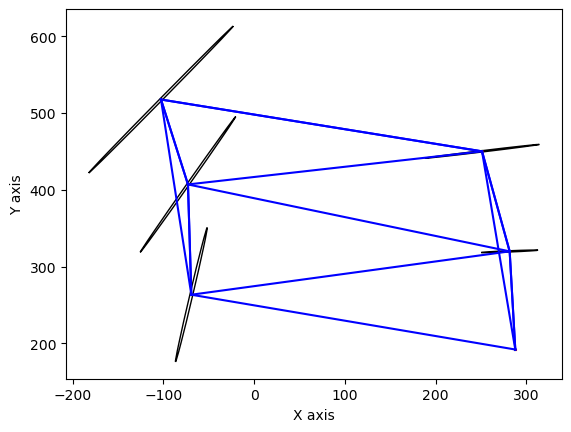

In [21]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [22]:
def extractAffineMatrixList(initial, image_list):
    poses = gtsam.utilities.allPose2s(initial)
    affine_matrix_list = []

    for index in range(len(image_list)):

        pose = poses.atPose2(index)
        #print(pose)
        #pose = [x * -1 for x in pose]
        affine_matrix = pose.matrix()
        #affine_matrix = np.linalg.inv(affine_matrix)
        translation_matrix = np.eye(3)

        translation_matrix[:2, 2] -= np.array([img_w/2, img_h/2]).T
        #print(affine_matrix.dot(translation_matrix))
        #affine_matrix_list.append(affine_matrix)
        affine_matrix_list.append(affine_matrix.dot(translation_matrix))
    
    #print(affine_matrix_list[0])
    affine_matrix_list.reverse()
    return affine_matrix_list

In [23]:
affine_matrix_list = extractAffineMatrixList(initial, imgs_norm)

In [24]:
def get_warp_point(homography_matrix, point):
    warp_point = homography_matrix.dot(np.append(point, [1]).T)
    return (warp_point / warp_point[-1])[:2]

In [25]:
def get_stitch_image_size_offset_affine_matrix(homography_matrix_list):
    corner_point_list = []

    for homography_matrix in homography_matrix_list:

        corner_point_list.append(get_warp_point(
            homography_matrix, [0, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [img_w - 1, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [img_w - 1, img_h - 1]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [0, img_h - 1]))

    min_point = (np.floor(np.amin(corner_point_list, axis=0))).astype(np.int32)
    max_point = (np.ceil(np.amax(corner_point_list, axis=0))).astype(np.int32)

    stitch_image_size = tuple(max_point - min_point + 1)

    offset_affine_matrix = np.eye(3, dtype=np.float64)
    if min_point[0] < 0:
        offset_affine_matrix[0, -1] -= min_point[0]
    if min_point[1] < 0:
        offset_affine_matrix[1, -1] -= min_point[1]
    return stitch_image_size, offset_affine_matrix

In [26]:
def alpha_blending(img1, img2):
    mask1 = cv2.inRange(img1,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask2 = cv2.inRange(img2,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask1 = cv2.bitwise_not(mask1)
    mask2 = cv2.bitwise_not(mask2)
    mask = cv2.bitwise_and(mask1, mask2)
    mask_inv = cv2.bitwise_not(mask)
    img1_fg = cv2.bitwise_and(img1,img1,mask = mask)
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    img_fg = cv2.addWeighted(img1_fg,0.7,img2_fg,0.3,0)
    img1_bg = cv2.bitwise_and(img1,img1,mask = cv2.bitwise_and(mask1,mask_inv))
    img2_bg = cv2.bitwise_and(img2,img2,mask = cv2.bitwise_and(mask2,mask_inv))
    img = cv2.add(img2_bg,img1_bg)
    img = cv2.add(img,img_fg)
    return img

In [27]:
def get_stitch_image(homography_matrix_list, image_list, stitch_image_size, offset_affine_matrix):

    stitch_image = np.zeros(
        (stitch_image_size[1], stitch_image_size[0], 3), np.uint8)
    print(stitch_image.shape)
    image_list.reverse()
    for homography_matrix, image in zip(homography_matrix_list, image_list):
        
        warp_image = cv2.warpPerspective(
            image, offset_affine_matrix.dot(homography_matrix), stitch_image_size)
        #plt.imshow(warp_image)
        #break
        warp_image_mask = (warp_image != 0)
        stitch_image[warp_image_mask] = warp_image[warp_image_mask]
        
        
        output = alpha_blending(stitch_image,warp_image)
    

    return output

(750, 995, 3)


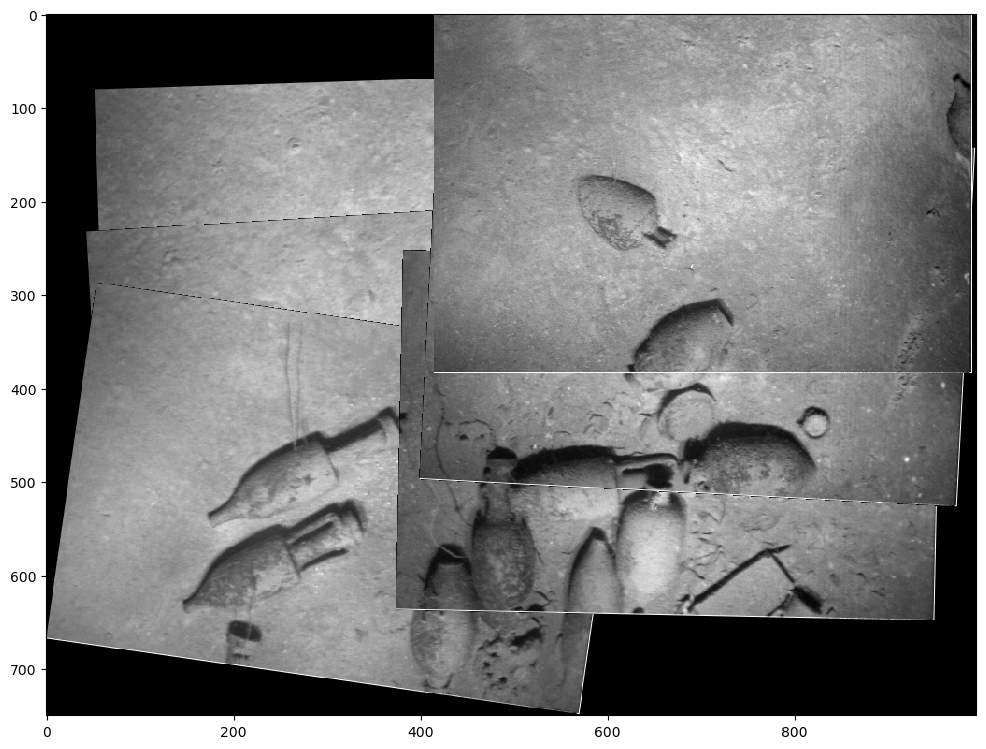

In [28]:
stitch_image_size, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

stitch_image = get_stitch_image(
    affine_matrix_list, imgs_norm, stitch_image_size, offset_affine_matrix)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image)
plt.show()